In [1]:
import sys
import numpy as np
sys.path.insert(0,'../..')
from pybandstructure.sample import *
import matplotlib.pyplot as plt
from os import remove
from pybandstructure.common import *

In [76]:
import scipy.spatial as spa
import numpy.linalg as lin
from itertools import product 
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as a3
import scipy as sp

from pybandstructure.geometry.point_groups import *
from time import time

In [3]:
class Wigner_Seitz_cell():
    def __init__(self, basis_vectors):
        ### nearest neighbour sample
        basis_vectors = Sample._check_input_vectors(basis_vectors)
        space_dimension, lattice_dimension = basis_vectors.shape
        cut_off = max([lin.norm(basis_vectors[:,i]) for i in range(lattice_dimension)]) * lattice_dimension
        nn = Sample.lattice_sample(basis_vectors, cut_off)
        ### voronoi diagram
        voronoi = spa.Voronoi(points = nn.coords)
        bz_indices = voronoi.regions[voronoi.point_region[nn[tuple([0 for _ in range(lattice_dimension)])]]]
        bz_vertices = voronoi.vertices[bz_indices]
        ### check volume
        bz_volume =  spa.ConvexHull(bz_vertices).volume
        assert np.allclose(bz_volume, abs(lin.det(nn.basis_vectors)))
        ### conversion to bz indices
        conversion = np.empty([len(voronoi.vertices)], dtype = int)
        conversion[:] = len(voronoi.vertices) 
        for i,index in enumerate(bz_indices):
            conversion[index] = i
        ### ridges
        bz_ridges = []
        for i,p in enumerate(voronoi.ridge_points):
            if nn[tuple([0 for _ in range(lattice_dimension)])] in p:
                bz_ridges.append(conversion[voronoi.ridge_vertices[i]])
        bz_ridges = np.array(bz_ridges)
        ### edges 
        if voronoi.ndim == 3:
            bz_edges = set()
            for r in bz_ridges:
                for i in range(len(r)):
                    if not (r[i],r[i-1]) in bz_edges:
                        bz_edges.add((r[i-1],r[i]))
            self.edges = bz_edges
        ###
        self.vertices = bz_vertices
        self.ridges = bz_ridges
        self.volume = bz_volume
        self.space_dimension = voronoi.ndim 
        self.nn = nn

In [4]:
def Wigner_Seitz_points(basis_vectors, denominator):
    basis_vectors = Sample._check_input_vectors(basis_vectors)
    space_dimension, lattice_dimension = basis_vectors.shape
    denominator = Sample._check_denominator(lattice_dimension, denominator)

    #cut_off = upper bound to the length of a vector that can be obtained by summing the basis vectors
    cut_off = max([lin.norm(basis_vectors[:,i]) for i in range(lattice_dimension)]) * lattice_dimension
    #create sample of lattice vectors close to the origin
    nn = Sample.lattice_sample(basis_vectors, cut_off)
    tree = spa.KDTree(nn.coords)
    standard_unit_cell = product(*[range(0, den, 1) for den in denominator])
    integer_coords = np.zeros([np.prod(denominator),basis_vectors.shape[1]], dtype = int)
    for j,k in enumerate(standard_unit_cell):
        v = nn.basis_vectors @ (k/denominator)
        index = tree.query(v)[1]
        integer_coords[j,:] = k-(nn.integer_coords[index]*denominator)
    coords = np.transpose(nn.basis_vectors @ np.transpose(integer_coords/denominator))
    return{'integer_coords' : integer_coords,
           'coords' : coords}

In [5]:
def irreducible_sample_points(basis_vectors, denominator, point_group, contiguous = True):
    basis_vectors = Sample._check_input_vectors(basis_vectors)
    space_dimension, lattice_dimension = basis_vectors.shape
    denominator = Sample._check_denominator(lattice_dimension, denominator)
    assert isinstance(point_group, Point_Group)
    symmetry_repr = point_group.integer_representation(basis_vectors)
    points = Wigner_Seitz_points(basis_vectors = basis_vectors, denominator = denominator)['integer_coords']
    orbits = []
    t1 = time()
    for p in points:
        orbit = set()
        for g in range(symmetry_repr.shape[0]):
                #careful with transpose
                gp = symmetry_repr[g,:,:].T @ p
                if not contiguous:
                    if gp.tolist() in points.tolist():
                        orbit.add(tuple(gp))
                else:
                    orbit.add(tuple(gp))
        if not orbit in orbits:
            orbits.append(orbit)
    t2 = time()        
    if contiguous:
        for i in range(len(orbits)):
            for j in range(i+1,len(orbits)):
                equal = False
                #for element1 in orbits[i]:
                #        break
                for element2 in orbits[j]:
                        break
                #n1 = lin.norm(basis_vectors @ (element1/denominator))
                #n2 = lin.norm(basis_vectors @ (element2/denominator))
                #if n1<=0.5 and np.allclose(n1,n2):
                for element in orbits[i]:
                    equal = equal or (not np.any(tdif(element,element2) % denominator))
                    if equal:
                        break
                if equal:
                    orbits[i] = orbits[i].union(orbits[j])
                    orbits[j] = set()
    t3 = time()
    if contiguous:
        orbits = [orbit for orbit in orbits if len(orbit)>0]
    integer_coords = []
    for i, orbit in enumerate(orbits):
        if contiguous:
            integer_coords.append(sorted(orbit, reverse = True)[0])
        else:
            for k in orbit:
                break
            integer_coords.append(k)
    integer_coords = np.array(integer_coords, dtype = int)
    t4 = time()
    return {'integer_coords' : integer_coords, 
            'orbits' : orbits, 
            'times' : (t2-t1, t3-t2, t4-t3, t4-t1),
            'basis_vectors' : basis_vectors,
            'denominator' : denominator,
            'symmetry_repr' : symmetry_repr}

### 2D Brillouin zone

In [6]:
basis_vectors = [[1,0.5],
                 [0,np.sqrt(3.)*.5]]
bz_2D = Wigner_Seitz_cell(basis_vectors)
pts = Wigner_Seitz_points(basis_vectors = basis_vectors, denominator = 11)

(-2.0, 2.0, -1.7320508075688772, 1.7320508075688772)

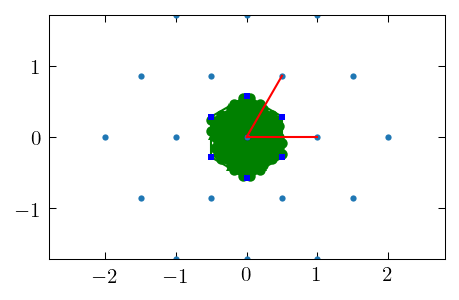

In [7]:
plt.plot(pts['coords'][:,0], pts['coords'][:,1],'go',ms=5)

for r in bz_2D.ridges:
    plt.plot([np.average(bz_2D.vertices[r,0])],
             [np.average(bz_2D.vertices[r,1])],'g^')
    plt.plot(bz_2D.vertices[r,0],bz_2D.vertices[r,1],'g-')

plt.plot(bz_2D.vertices[:,0], bz_2D.vertices[:,1], 'bs')
plt.plot([np.average(bz_2D.vertices[:,0])],
         [np.average(bz_2D.vertices[:,1])],'ko')
bz_2D.nn.plot()
plt.axis('equal')

### 3D Brillouin zone

In [8]:
# basis_vectors = Sample._check_input_vectors([[1,0.5,0],
#                                              [0,np.sqrt(3)/2,0],
#                                              [0,0,1]])
# basis_vectors = Sample._check_input_vectors([[1,0,0.5],
#                                  [0,1,0.5],
#                                  [0,0,0.5]])
basis_vectors = Sample._check_input_vectors([[1,0,0],
                                  [0,1,0],
                                  [0,0,1]])
# basis_vectors = Sample._check_input_vectors([[1,0,0.5],
#                                  [0,1,0.],
#                                  [0,0,0.5]])
bz_3D = Wigner_Seitz_cell(basis_vectors)
pts3d = Wigner_Seitz_points(basis_vectors = basis_vectors, denominator = (3,3,3))

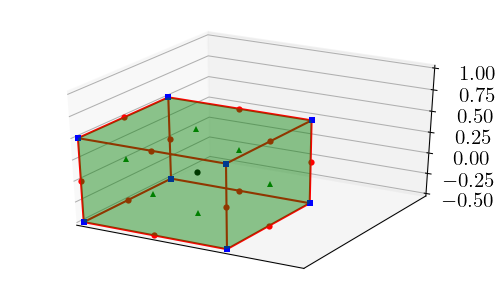

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(lattice.coords[:,0], lattice.coords[:,1], lattice.coords[:,2],'.')
for r in bz_3D.ridges:
    tri = a3.art3d.Poly3DCollection([bz_3D.vertices[r,:]],color='g', alpha =0.25)
    tri.set_edgecolor(None)
    ax.add_collection3d(tri)
    plt.plot([np.average(bz_3D.vertices[r,0])],
             [np.average(bz_3D.vertices[r,1])],
             [np.average(bz_3D.vertices[r,2])],'g^')
for e in bz_3D.edges:
    plt.plot(bz_3D.vertices[e,0],bz_3D.vertices[e,1],bz_3D.vertices[e,2],'r-')
    plt.plot([np.average(bz_3D.vertices[e,0])],
             [np.average(bz_3D.vertices[e,1])],
             [np.average(bz_3D.vertices[e,2])],'ro')
ax.plot(bz_3D.vertices[:,0], bz_3D.vertices[:,1], bz_3D.vertices[:,2], 'bs')
plt.plot([np.average(bz_3D.vertices[:,0])],
         [np.average(bz_3D.vertices[:,1])],
         [np.average(bz_3D.vertices[:,2])],'ko')
plt.xticks([])
plt.yticks([])
plt.tight_layout()


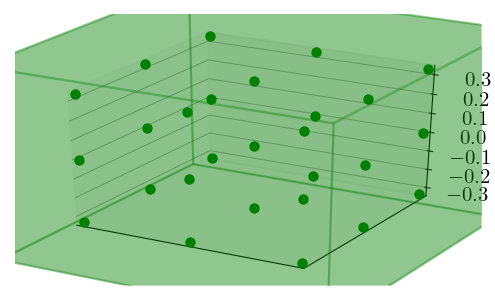

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(lattice.coords[:,0], lattice.coords[:,1], lattice.coords[:,2],'.')
plt.plot(pts3d['coords'][:,0], pts3d['coords'][:,1],pts3d['coords'][:,2],'go',ms=5)
for r in bz_3D.ridges:
    tri = a3.art3d.Poly3DCollection([bz_3D.vertices[r,:]],color='g', alpha =0.25)
    tri.set_edgecolor('g')
    ax.add_collection3d(tri)



plt.xticks([])
plt.yticks([])
plt.tight_layout()

(-0.5, 0.5, -0.5, 0.5)

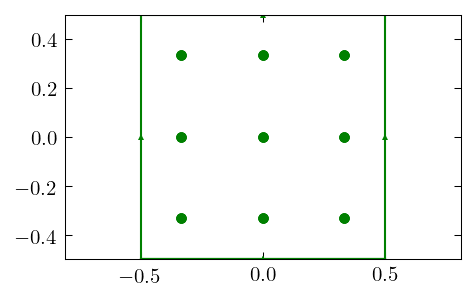

In [11]:
for r in bz_2D.ridges:
    plt.plot([np.average(bz_3D.vertices[r,0])],
             [np.average(bz_3D.vertices[r,1])],'g^')
    plt.plot(bz_3D.vertices[r,0],bz_3D.vertices[r,1],'g-')
plt.plot(pts3d['coords'][:,0], pts3d['coords'][:,1],'go',ms=5)
plt.axis('equal')

## Reduced BZ

In [100]:
basis_vectors = [[1,           0.5],
                 [0,np.sqrt(3.)*.5]]
#basis_vectors = [[1,0],
#                 [0,1]]
denominator = 7
point_group = D6_2D(theta0 = np.arctan2(basis_vectors[1][0], basis_vectors[0][0]))
#point_group = D4_2D(theta0 = np.arctan2(basis_vectors[1][0], basis_vectors[0][0]))

bz = Wigner_Seitz_cell(basis_vectors)
irrbz = irreducible_sample_points(basis_vectors = basis_vectors, 
                                  denominator = denominator, 
                                  point_group = point_group,
                                  contiguous = True)

(-0.5, 0.5, -0.5773502691896257, 0.5773502691896257)

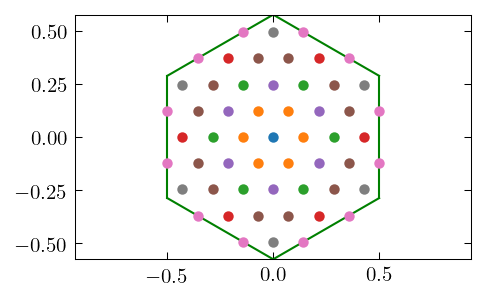

In [101]:
for r in bz.ridges:
    plt.plot(bz.vertices[r,0],bz.vertices[r,1],'g-')
for orbit in irrbz['orbits']:
    arr = np.array([*orbit])
    coords = np.transpose(irrbz['basis_vectors'] @ np.transpose(arr/irrbz['denominator']))
    plt.plot(coords[:,0],coords[:,1],'o',ms=5)
plt.axis('equal')

(-0.5, 0.5, -0.5773502691896257, 0.5773502691896257)

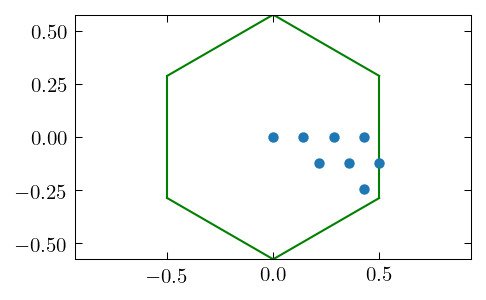

In [102]:
for r in bz.ridges:
    plt.plot(bz.vertices[r,0],bz.vertices[r,1],'g-')
coords = np.transpose(basis_vectors @ np.transpose(irrbz['integer_coords']/irrbz['denominator']))
plt.plot(coords[:,0],coords[:,1],'o',ms=5)


plt.axis('equal')

In [103]:

def _build_db(denominator, integer_coords, symmetry_repr):
    '''Build the point database given the representation of the 
    symmetry group.'''
    dict_ = {}
    for g in range(symmetry_repr.shape[0]-1,-1,-1):
        for i,key in enumerate(integer_coords):
            #careful with transpose
            vector = symmetry_repr[g,:,:].T @ np.array(key, dtype = int)
            dict_[Sample._get_fractional_part(vector, denominator)] = {'index' : i, 'operation' : g} 
    return dict_


def _build_weights(denominator, integer_coords, points_db):
    '''Build the weights given the point database.'''
    integration_weights = np.zeros([len(integer_coords)], dtype = float)
    standard_bz = product(*[range(den) for den in denominator])
    for k in standard_bz:
        integration_weights[points_db[k]['index']] += 1
    return integration_weights / np.prod(denominator)

In [104]:
_dic = _build_db(denominator = irrbz['denominator'], integer_coords = irrbz['integer_coords'], symmetry_repr= irrbz['symmetry_repr'])

In [105]:
len(_dic)

49

In [106]:
w = _build_weights(denominator = irrbz['denominator'], integer_coords = irrbz['integer_coords'], points_db =_dic)

In [107]:
w.shape

(8,)

(-0.5, 0.503790606876161, -0.5773502691896257, 0.5773502691896257)

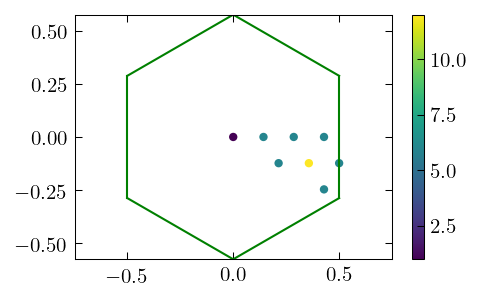

In [108]:
for r in bz.ridges:
    plt.plot(bz.vertices[r,0],
             bz.vertices[r,1],'g-')
coords = np.transpose(irrbz['basis_vectors'] @ np.transpose(irrbz['integer_coords']/irrbz['denominator']))
plt.scatter(coords[:,0],coords[:,1],c= w*np.prod(irrbz['denominator']))
plt.colorbar()
plt.axis('equal')